# Household Power Consumption

## Section 1 - Project Overview

In this project, we will be studying some household power consumption over time using LSTM.

## Section 2 - Data Preprocessing

### Import Libraries

In [1]:
import tensorflow as tf
import pandas as pd
import os
import requests

In [3]:
#Support from microsoft copilot to help convert floats

import pandas as pd

# Step 1: Define the file path
file_path = 'household_power_consumption.txt'

# Step 2: Read the .txt file with ';' as delimiter
df = pd.read_csv(file_path, delimiter=';', low_memory=False)

# Step 3: Convert relevant columns to numeric, forcing conversion and setting errors to NaN
columns_to_convert = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2']
for column in columns_to_convert: df[column] = pd.to_numeric(df[column], errors='coerce')

# Step 4: Handle missing values (forward fill in this example)
df = df.fillna(method='ffill')

# Step 5: Check the DataFrame info to ensure correct types
print(df.info())

C:\Users\nikol\AppData\Local\Temp\ipykernel_5700\1769041611.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    float64
 3   Global_reactive_power  float64
 4   Voltage                float64
 5   Global_intensity       float64
 6   Sub_metering_1         float64
 7   Sub_metering_2         float64
 8   Sub_metering_3         float64
dtypes: float64(7), object(2)
memory usage: 142.5+ MB
None


Exploring the dataset

In [4]:
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [5]:
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06
mean,1.086168e+00,1.233280e-01,2.408416e+02,4.604226e+00,1.110995e+00,1.287958e+00,6.416570e+00
std,1.053172e+00,1.125144e-01,3.235574e+00,4.426775e+00,6.115908e+00,5.786865e+00,8.419505e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.390000e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.980000e-01,1.000000e-01,2.410200e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.524000e+00,1.940000e-01,2.428700e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    float64
 3   Global_reactive_power  float64
 4   Voltage                float64
 5   Global_intensity       float64
 6   Sub_metering_1         float64
 7   Sub_metering_2         float64
 8   Sub_metering_3         float64
dtypes: float64(7), object(2)
memory usage: 142.5+ MB


### Exploring the Data

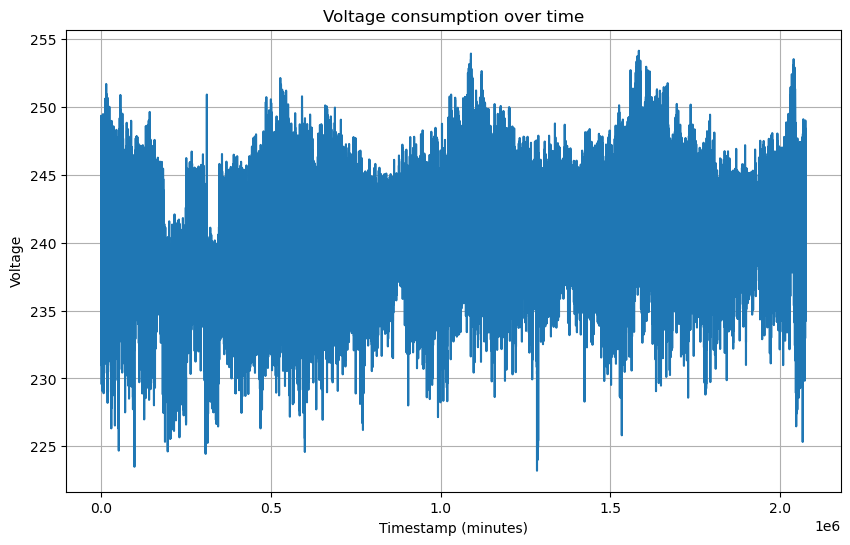

In [7]:
# Create a numeric time vector
time = pd.Series(range(len(df)))
series = df['Voltage']

import matplotlib.pyplot as plt

# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(time, series)
plt.title("Voltage consumption over time")
plt.xlabel("Timestamp (minutes)")
plt.ylabel("Voltage")
plt.grid(True)
plt.show()

Looking at Power

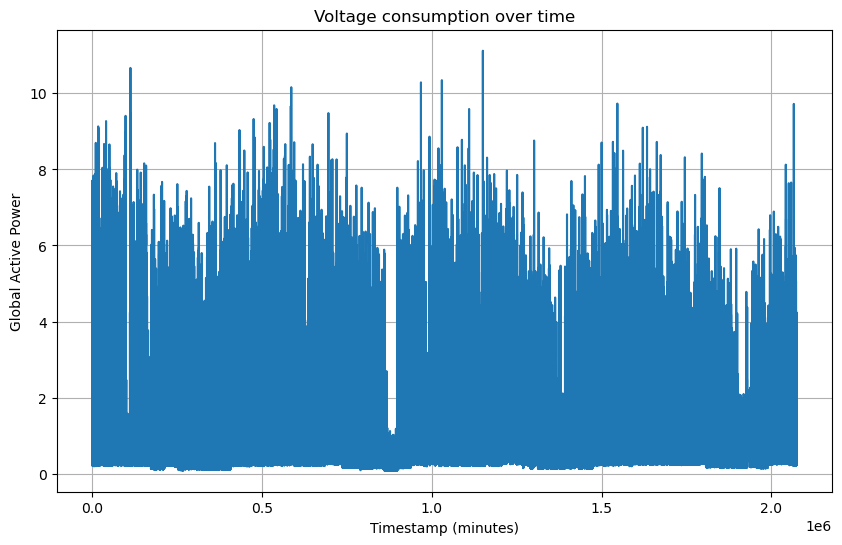

In [8]:
# Create a numeric time vector
time = pd.Series(range(len(df)))
series = df['Global_active_power']

# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(time, series)
plt.title("Voltage consumption over time")
plt.xlabel("Timestamp (minutes)")
plt.ylabel("Global Active Power")
plt.grid(True)
plt.show()

Overall we see fairly consistent trend data

### Split the test and training set

In [9]:
split_time = int(10000)

# train data
time_train = time[:split_time]
x_train = series[:split_time]

# validation dataset
time_valid = time[split_time:]
x_valid = series[split_time:]

### Preprocessing

In [10]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Normalize the series using MinMaxScaler
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(np.array(x_train).reshape(-1, 1)).flatten()
x_valid_scaled = scaler.transform(np.array(x_valid).reshape(-1, 1)).flatten()


### Preparing Features

In [11]:
def window_dataset(series, window_size, batch_size, shuffle_buffer):
    # Convert the series to a tf.data.Dataset
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Create windows of size (window_size + 1) with a shift of 1
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten each window into a single batch so each window is a tensor
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Split each window into features (window[:-1]) and label (window[-1])
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the dataset with a buffer
    dataset = dataset.shuffle(shuffle_buffer)

    # Batch the dataset and use prefetching for optimized data loading
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [12]:
# parameters
window_size = 20
batch_size = 8
shuffle_buffer_size = 500

# Generate the training dataset using the defined function
train_set = window_dataset(x_train_scaled, window_size, batch_size, shuffle_buffer_size)
val_set = window_dataset(x_valid_scaled, window_size, batch_size, shuffle_buffer_size)

## Section 3 - Building & Training the Model

### Build the model

In [13]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, return_sequences=True, input_shape=[window_size, 1]),
    tf.keras.layers.Dense(8, activation="relu"),
    tf.keras.layers.Dense(1)
])

# Compile the model with loss and optimizer
learning_rate = 0.1
model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

model.summary()

C:\Users\nikol\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 20, 8)               │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 20, 8)               │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 20, 1)               │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 401 (1.57 KB)

 Trainable params: 401 (1.57 KB)

 Non-trainable params: 0 (0.00 B)

### Train the model (this model was excluded due to the amount of time it was taking to run)

history = model.fit(train_set, epochs=10, validation_data=val_set, verbose=0)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

def model_forecast(model, series, window_size):
    series = np.array(series)
    forecast = []
    for time in range(len(series) - window_size):
        window = series[time:time + window_size]
        window = window.reshape((1, window_size, 1))
        prediction = model.predict(window, verbose=0)
        forecast.append(prediction[0, 0])
    return np.array(forecast)

# Forecasting
forecast = model_forecast(model, x_valid_scaled, window_size)

# Rescale forecasted values back to the original scale
forecast_rescaled = scaler.inverse_transform(forecast.reshape(-1, 1)).flatten()

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(time_valid[window_size:], x_valid[window_size:], label="Actual")
plt.plot(time_valid[window_size:], forecast_rescaled, label="Forecasted")
plt.title("Actual vs Forecasted Global Power")
plt.xlabel("Time")
plt.ylabel("Global Power")
plt.legend()
plt.show()

# Predicting on the training dataset
train_forecast = model_forecast(model, x_train_scaled, window_size)
# Rescale the training forecast back to the original scale
train_forecast_rescaled = scaler.inverse_transform(train_forecast.reshape(-1, 1)).flatten()

# Predicting on the validation dataset
val_forecast = model_forecast(model, x_valid_scaled, window_size)
# Rescale the validation forecast back to the original scale
val_forecast_rescaled = scaler.inverse_transform(val_forecast.reshape(-1, 1)).flatten()

# Plotting both training and validation predictions along with the actual series
plt.figure(figsize=(12, 6))

# Training set plot
plt.plot(time_train[window_size:], x_train[window_size:], label="Training Data (Actual)")
plt.plot(time_train[window_size:], train_forecast_rescaled, label="Training Data (Forecasted)", linestyle="--")

# Validation set plot
plt.plot(time_valid[window_size:], x_valid[window_size:], label="Validation Data (Actual)")
plt.plot(time_valid[window_size:], val_forecast_rescaled, label="Validation Data (Forecasted)", linestyle="--")

# Formatting the plot
plt.title("Training and Validation Forecasts")
plt.xlabel("Time")
plt.ylabel("Global Power")
plt.legend()
plt.grid(True)
plt.show()

from sklearn.metrics import mean_squared_error

# Calculate MSE for the simple LSTM model
train_mse_simple = mean_squared_error(x_train[window_size:], train_forecast)
val_mse_simple = mean_squared_error(x_valid[window_size:], val_forecast)

### Keras Models

In [14]:
from tensorflow.keras import layers, models

# Define the model
model = models.Sequential([
    # 1. Convolutional Layer to learn short-term patterns
    layers.Conv1D(filters=8, kernel_size=2, activation="relu", input_shape=[window_size, 1]),
    #layers.MaxPooling1D(pool_size=2),  # Optional pooling layer to reduce dimensionality

    # 2. LSTM Layer for capturing temporal dependencies
    layers.LSTM(8, return_sequences=True),

    # 3. Dense Layers (DNN) for final prediction
    layers.Dense(8, activation="relu"),
    layers.Dense(1)  # Final output layer for regression
])

# Compile the model
model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

model.summary()

C:\Users\nikol\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 19, 8)               │              24 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 19, 8)               │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 19, 8)               │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 19, 1)               │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 649 (2.54 KB)

 Trainable params: 649 (2.54 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Train the model
history = model.fit(train_set, epochs=10)

Epoch 1/10
1248/1248 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0373
Epoch 2/10
   6/1248 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - loss: 0.0204 

C:\Users\nikol\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1248/1248 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0238
Epoch 3/10
1248/1248 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0239
Epoch 4/10
1248/1248 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0238
Epoch 5/10
1248/1248 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0237
Epoch 6/10
1248/1248 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0239
Epoch 7/10
1248/1248 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0238
Epoch 8/10
1248/1248 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0239
Epoch 9/10
1248/1248 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0242
Epoch 10/10
1248/1248 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0239


Support with chatgtp to accelerate the review

In [16]:
def model_forecast(model, series, window_size, batch_size=128):
  series = np.array(series)
  forecast = []
  for time in range(0, len(series) - window_size, batch_size):
    batch_end = min(time + batch_size, len(series) - window_size)
    windows = np.array([series[i:i + window_size] for i in range(time, batch_end)])
    windows = windows.reshape((windows.shape[0], window_size, 1))
    predictions = model.predict(windows, verbose=0)
    forecast.extend(predictions[:, 0])
  return np.array(forecast)

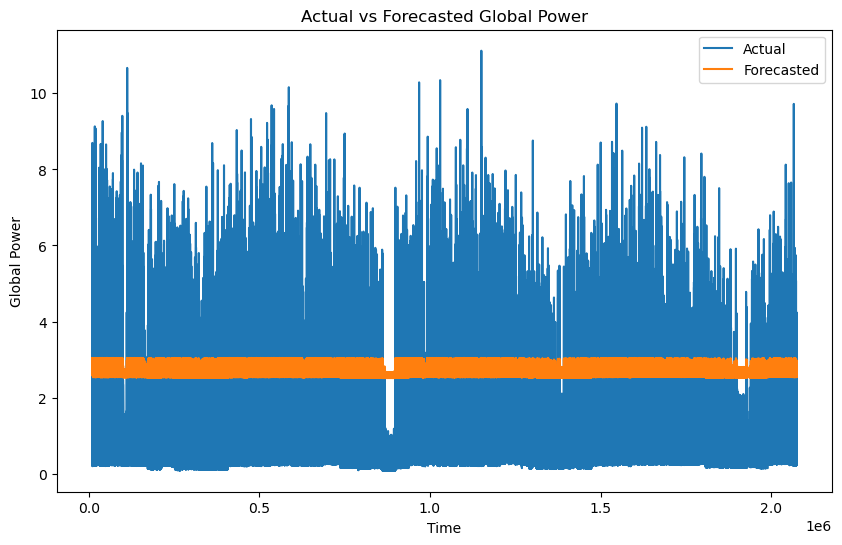

In [17]:
# Forecasting
forecast = model_forecast(model, x_valid_scaled, window_size)

# Rescale forecasted values back to the original scale
forecast_rescaled = scaler.inverse_transform(forecast.reshape(-1, 1)).flatten()

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(time_valid[window_size:], x_valid[window_size:], label="Actual")
plt.plot(time_valid[window_size:], forecast_rescaled, label="Forecasted")
plt.title("Actual vs Forecasted Global Power")
plt.xlabel("Time")
plt.ylabel("Global Power")
plt.legend()
plt.show()

In [18]:
from sklearn.metrics import mean_squared_error

# Evaluate the CNN-LSTM-DNN cascaded model
# Forecasting on training and validation sets
train_forecast_cascaded = model_forecast(model, x_train_scaled, window_size)
val_forecast_cascaded = model_forecast(model, x_valid_scaled, window_size)

# Rescale the forecasts back to the original scale
train_forecast_cascaded_rescaled = scaler.inverse_transform(train_forecast_cascaded.reshape(-1, 1)).flatten()
val_forecast_cascaded_rescaled = scaler.inverse_transform(val_forecast_cascaded.reshape(-1, 1)).flatten()

# Calculate MSE for the cascaded CNN-LSTM-DNN model
train_mse_cascaded = mean_squared_error(x_train[window_size:], train_forecast_cascaded_rescaled)
val_mse_cascaded = mean_squared_error(x_valid[window_size:], val_forecast_cascaded_rescaled)

## Section 4 - Model Comparison

In [19]:
from sklearn.metrics import mean_squared_error

# Predicting on the training & validation dataset
train_forecast = model_forecast(model, x_train_scaled, window_size)
val_forecast = model_forecast(model, x_valid_scaled, window_size)

# Calculate MSE for the simple LSTM model
train_mse_simple = mean_squared_error(x_train[window_size:], train_forecast)
val_mse_simple = mean_squared_error(x_valid[window_size:], val_forecast)

# Compile the results into a DataFrame for easy comparison
results = pd.DataFrame({
    "Model": ["Simple LSTM", "Cascaded CNN-LSTM-DNN"],
    "Training MSE": [train_mse_simple, train_mse_cascaded],
    "Validation MSE": [val_mse_simple, val_mse_cascaded]
})

# Display the comparison table
print("Comparison of Training and Validation MSE:")
print(results)

Comparison of Training and Validation MSE:
                   Model  Training MSE  Validation MSE
0            Simple LSTM      3.731515        1.660540
1  Cascaded CNN-LSTM-DNN      2.523926        3.415227
